In [308]:
import numpy as np
import matplotlib.pyplot as plt
import random
import pylab as py

## Campo de um dipolo

In [309]:
#criando grid. Atemporal
xmin = -3000.0
xmax = 3000.0
nx = 200

ymin = -3000.0
ymax = 3000.0
ny = 200

x = np.linspace(xmin, xmax, nx) # metros
y = np.linspace(ymin, ymax, ny) # metros
z = 0 # metros
X,Y = np.meshgrid(x,y)

In [310]:
#campo magnético de um dipolo

#localização
xc = 0
yc = 0
zc = -1000

#constante
C = 10e-7

m_v = np.array([30,15,6])
m = np.sqrt(m_v[0]**2 + m_v[1]**2 + m_v[2]**2)

r = np.sqrt( (X-xc)**2 + (Y-yc)**2 + (z-zc)**2 )

#ilustração, precisa revisar
cos_theta = (m_v[0]*X + m_v[1]*Y + m_v[2]*zc)/(r*m)
B_dipolo = C*m*3*cos_theta/(r*r*r)

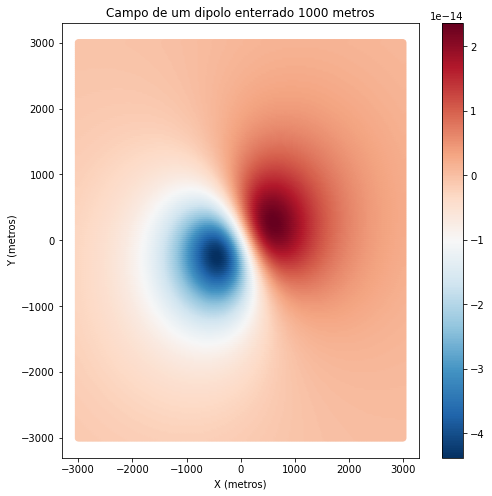

In [311]:
plt.scatter(X,Y,c=B_dipolo,cmap = plt.cm.RdBu_r)
plt.xlabel('X (metros)')
plt.ylabel('Y (metros)')
plt.title('Campo de um dipolo enterrado %i metros'%-zc)
plt.colorbar()
plt.show()

## Variação Diurna

In [312]:
# dados da estação base
F = 23500.0 # Campo regional em nT
vB = 50.0   # amplitude da variacao diurna em nT

hora = np.linspace(0.0, 24.0, 1000, endpoint=True)
B = []
for h in hora:
    if h >= 6.0 and h <= 18.0:
        B.append(F + vB * np.sin((np.pi/12.0) * (h-6.0) ) + random.normalvariate(0.0, 1.0))
    else:
        B.append(F + random.normalvariate(0.0,1.0) )

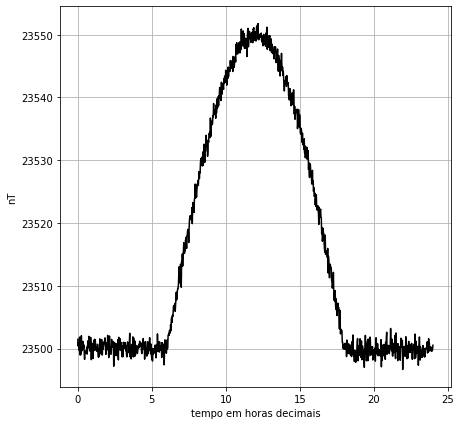

In [313]:
plt.figure(figsize=(7,7))
plt.plot(hora, B, 'k-')
plt.xlabel('tempo em horas decimais')
plt.grid()
plt.ylabel('nT')
plt.show()

## Simulação de uma aquisição. Dados em função do tempo

In [314]:
#criando grid de observações em função do tempo
xmin = -3000
xmax = 3000
nx = 100

ymin = -3000
ymax = 3000
ny = 200

dados_xyBt = [[],[],[],[]]

for i in range(xmin,xmax,nx):
    for j in range(ymin,ymax,ny):
        dados_xyBt[0] += [i]
        dados_xyBt[1] += [j]
        dados_xyBt[2] += [None]
        dados_xyBt[3] += [None]

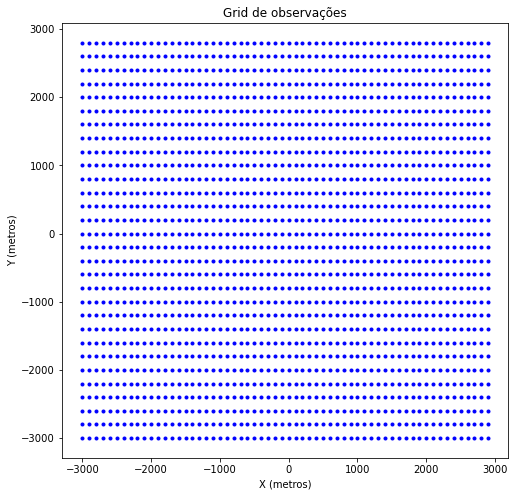

In [315]:
# vizualizacao do grid de observacoes em função do tempo
py.rcParams['figure.figsize'] = (8.0, 8.0) #Redimensiona a figura
plt.plot(dados_xyBt[0],dados_xyBt[1],'.b')
plt.xlabel('X (metros)')
plt.ylabel('Y (metros)')
plt.title('Grid de observações')
plt.show()